### Imports

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import energyflow as ef

import importlib.util
import sys 

def import_module_from_path(module_name, file_path):
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module

omnifold_bdt = import_module_from_path("omnifold", "../unfolding/omnifold.py")
data_handler = import_module_from_path("data_handler", "../unfolding/data_handler.py")

omnifold_dnn = import_module_from_path("omnifold", "../OmniFold/omnifold.py")
modplot = import_module_from_path("modplot", "../OmniFold/modplot.py")
ibu = import_module_from_path("ibu", "../OmniFold/ibu.py")

### Settings

In [54]:
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'serif'

num_data = 100000
itnum = 3

In [55]:
datasets = {'Pythia26': ef.zjets_delphes.load('Pythia26', num_data=num_data, exclude_keys=['particles']),
            'Herwig': ef.zjets_delphes.load('Herwig', num_data=num_data, exclude_keys=['particles'])}

In [56]:
# choose what is MC and Data in this context
synthetic, nature = datasets['Pythia26'], datasets['Herwig']

In [57]:
obs_multifold = ['Mass', 'Mult', 'Width', 'Tau21', 'zg', 'SDMass']

In [58]:
# a dictionary to hold information about the observables
obs = {}

# the jet mass and histogram style information
obs.setdefault('Mass', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_jets'][:,3],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 75), 'ylim': (0, 0.065),
    'xlabel': r'Jet Mass $m$ [GeV]', 'symbol': r'$m$',
    'ylabel': r'Normalized Cross Section [GeV$^{-1}$]',
    'stamp_xy': (0.425, 0.65),
})

# the constituent multiplicity and histogram style information
obs.setdefault('Mult', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_mults'],
    'nbins_det': 80, 'nbins_mc': 80,
    'xlim': (0, 80), 'ylim': (0, 0.065),
    'xlabel': 'Jet Constituent Multiplicity $M$', 'symbol': r'$M$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.42, 0.65),
})

# the jet width and histogram style information
obs.setdefault('Width', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_widths'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 0.6), 'ylim': (0, 10),
    'xlabel': r'Jet Width $w$', 'symbol': r'$w$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.425, 0.65),
})

# the N-subjettiness ratio and histogram style information
obs.setdefault('Tau21', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_tau2s']/(dset[ptype + '_widths'] + 10**-50),
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 1.2), 'ylim': (0, 3),
    'xlabel': r'$N$-subjettiness Ratio $\tau_{21}^{(\beta=1)}$', 'symbol': r'$\tau_{21}^{(\beta=1)}$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.41, 0.92),
    'legend_loc': 'upper left', 'legend_ncol': 1,
})

# the groomed momentum fraction and histogram style information
obs.setdefault('zg', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_zgs'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 0.5), 'ylim': (0, 9),
    'xlabel': r'Groomed Jet Momentum Fraction $z_g$', 'symbol': r'$z_g$',
    'ylabel': 'Normalized Cross Section',
    'stamp_xy': (0.425, 0.65),
})

# the groomed jet mass and histogram style information
obs.setdefault('SDMass', {}).update({
    'func': lambda dset, 
    ptype: np.log(dset[ptype + '_sdms']**2/
                                       dset[ptype + '_jets'][:,0]**2 + 10**-100),
    'nbins_det': 50, 
    'nbins_mc': 50,
    'xlim': (-14, -2), 'ylim': (0, 0.3),
    'xlabel': r'Soft Drop Jet Mass $\ln\rho$', 'symbol': r'$\ln\rho$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.41, 0.92),
    'legend_loc': 'upper left', 'legend_ncol': 1,
})

# additional histogram and plot style information
hist_style = {'histtype': 'step', 'density': True, 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '--', 'color': 'blue', 'lw': 1.15, 'label': 'Gen.'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': '"Truth"'}
ibu_style = {'ls': '-', 'marker': 'o', 'ms': 2.5, 'color': 'gray', 'zorder': 1}
omnifold_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:red', 'zorder': 3}

Now all that remains is to get the values of the specified observables and compute the histograms with the specified binnings. As an unfolding benchmark, we also obtain the unfolding results of Iterative Bayesian Unfolding (IBU) as implemented in `ibu.py`. The following cell takes care of all of these aspects.

In [59]:
# calculate quantities to be stored in obs
for obkey,ob in obs.items():
    
    # calculate observable for GEN, SIM, DATA, and TRUE
    ob['genobs'], ob['simobs'] = ob['func'](synthetic, 'gen'), ob['func'](synthetic, 'sim')
    ob['truthobs'], ob['dataobs'] = ob['func'](nature, 'gen'), ob['func'](nature, 'sim')
    
    # setup bins
    ob['bins_det'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_det']+1)
    ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    ob['midbins_det'] = (ob['bins_det'][:-1] + ob['bins_det'][1:])/2
    ob['midbins_mc'] = (ob['bins_mc'][:-1] + ob['bins_mc'][1:])/2
    ob['binwidth_det'] = ob['bins_det'][1] - ob['bins_det'][0]
    ob['binwidth_mc'] = ob['bins_mc'][1] - ob['bins_mc'][0]
    
    # get the histograms of GEN, DATA, and TRUTH level observables
    ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'], density=True)[0]
    ob['data_hist'] = np.histogram(ob['dataobs'], bins=ob['bins_det'], density=True)[0]
    ob['truth_hist'], ob['truth_hist_unc'] = modplot.calc_hist(ob['truthobs'], bins=ob['bins_mc'], 
                                                               density=True)[:2]

    # compute (and normalize) the response matrix between GEN and SIM
    ob['response'] = np.histogram2d(ob['simobs'], ob['genobs'], bins=(ob['bins_det'], ob['bins_mc']))[0]
    ob['response'] /= (ob['response'].sum(axis=0) + 10**-50)
    
    # perform iterative Bayesian unfolding
    ob['ibu_phis'] = ibu.ibu(ob['data_hist'], ob['response'], ob['genobs_hist'], 
                         ob['binwidth_det'], ob['binwidth_mc'], it=itnum)
    ob['ibu_phi_unc'] = ibu.ibu_unc(ob, it=itnum, nresamples=25)
    
    print('Done with', obkey)

Done with Mass
Done with Mult
Done with Width
Done with Tau21
Done with zg
Done with SDMass


## BDT OmniFold

In [60]:

mc_entries = np.asarray([(obs[obkey]['genobs']) for obkey in obs_multifold]).T
sim_entries = np.asarray([(obs[obkey]['simobs']) for obkey in obs_multifold]).T
measured_entries = np.asarray([(obs[obkey]['dataobs']) for obkey in obs_multifold]).T

pass_reco_mask = np.full(num_data, True)
pass_truth_mask = np.full(num_data, True)

The `omnifold` method within `omnifold.py` takes all the relevant information and performs the unfolding process for the specified number of iterations.

In [61]:
# apply the OmniFold procedure to get weights for the generation
multifold_ws, MC_test, _, _ = omnifold_bdt.unbinned_omnifold(
    mc_entries, 
    sim_entries, 
    measured_entries, 
    pass_reco_mask, 
    pass_truth_mask, 
    itnum
)

Starting iteration 0
Starting iteration 1
Starting iteration 2


In [62]:
print(multifold_ws[-1][1].shape)
print(MC_test.shape)

(50000,)
(50000, 6)


## Plot Unfolding Results

Now it's time to plot the unfolding results for all of the specified observables!

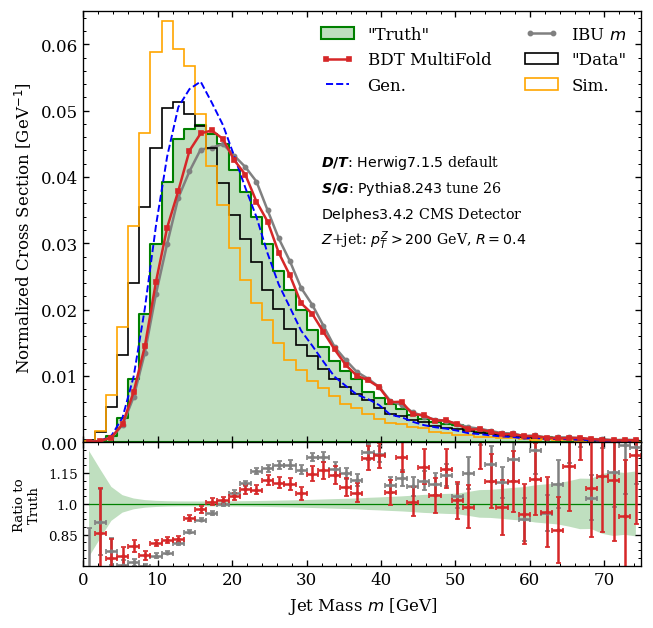

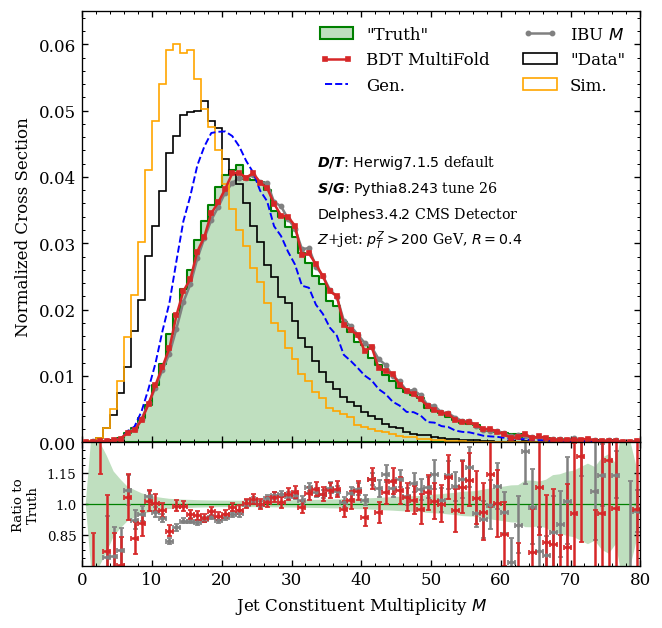

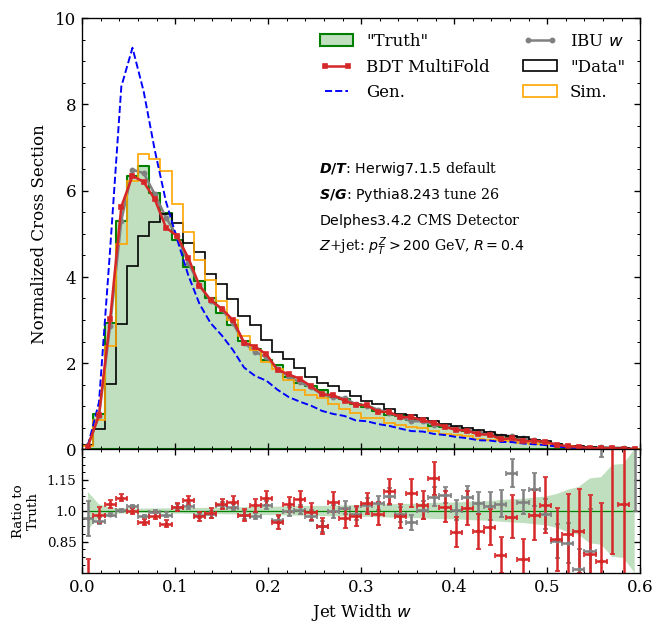

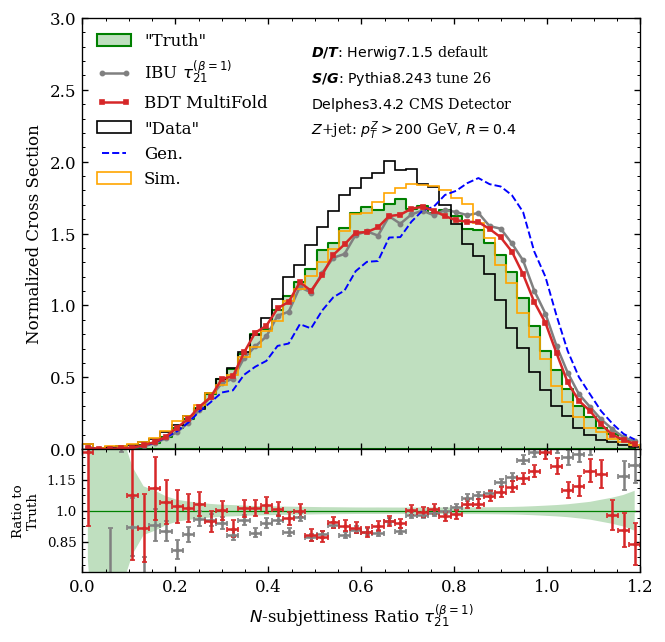

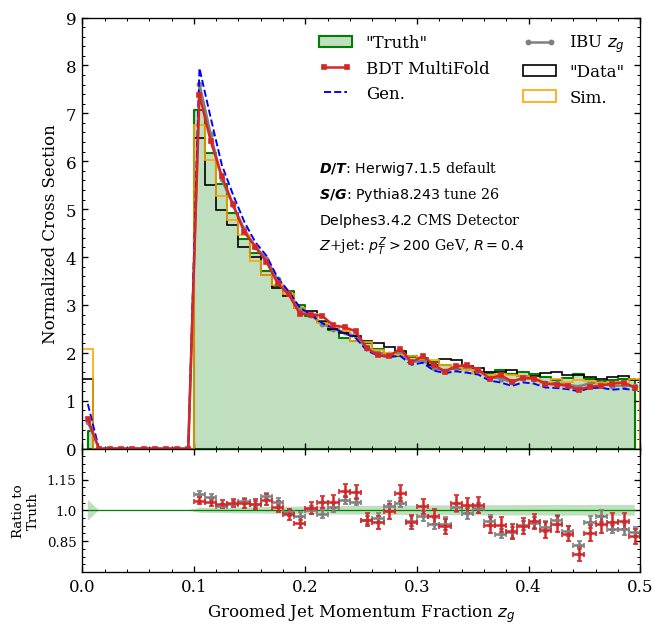

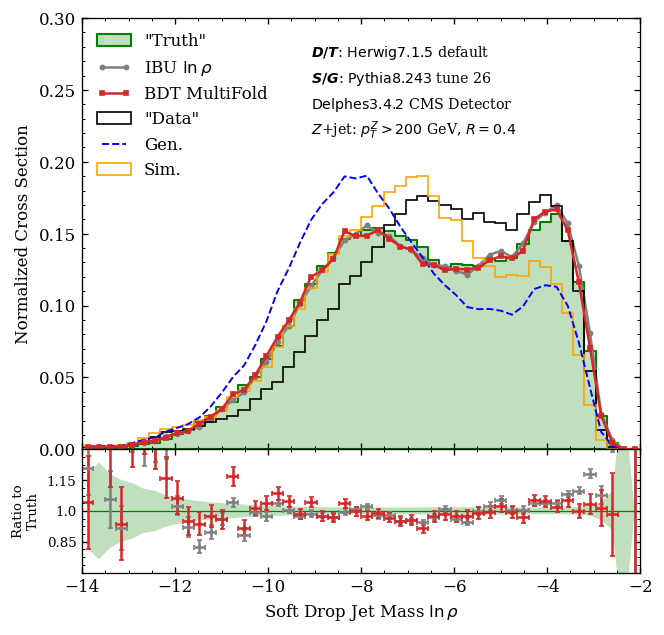

In [64]:
for i,(obkey,ob) in enumerate(obs.items()):
    
    # get the styled axes on which to plot
    fig, [ax0, ax1] = modplot.axes(**ob, figsize=(6,6))
    if ob.get('yscale') is not None:
        ax0.set_yscale(ob['yscale'])

    # Plot the Different Distributions of the Observable
    # plot the "data" histogram of the observable
    ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='"Data"', **hist_style)
    ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='Sim.', **hist_style)
    ax0.plot(ob['midbins_mc'], ob['genobs_hist'], **gen_style)
    ax0.fill_between(ob['midbins_mc'], ob['truth_hist'], **truth_style)

    
    # Plot the Unfolded Distributions of the Observable
    # plot the OmniFold distribution    
    of_histgen, of_histgen_unc = modplot.calc_hist(
        MC_test[:,i], 
        weights=multifold_ws[-1][1],        
        bins=ob['bins_mc'], 
        density=True
    )[:2]
    
    # plot the OmniFold distribution
    ax0.plot(ob['midbins_mc'], of_histgen, **omnifold_style, label='BDT MultiFold')

    # plot the IBU distribution
    ax0.plot(ob['midbins_mc'], ob['ibu_phis'][itnum], **ibu_style, label='IBU ' + ob['symbol'])

    # Plot the Ratios of the OmniFold and IBU distributions to truth (with statistical uncertainties)
    ibu_ratio = ob['ibu_phis'][itnum] / (ob['truth_hist'] + 10**-50)
    of_ratio = of_histgen / (ob['truth_hist'] + 10**-50)
    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
    
    # ratio uncertainties
    truth_unc_ratio = ob['truth_hist_unc'] / (ob['truth_hist'] + 10**-50)
    ibu_unc_ratio = ob['ibu_phi_unc'] / (ob['truth_hist'] + 10**-50)
    of_unc_ratio = of_histgen_unc / (ob['truth_hist'] + 10**-50)
    
    ax1.fill_between(
        ob['midbins_mc'], 
        1 - truth_unc_ratio, 
        1 + truth_unc_ratio,      
        facecolor=truth_style['facecolor'],
        zorder=-2
    )

    ax1.errorbar(
        ob['midbins_mc'], 
        ibu_ratio, 
        xerr=ob['binwidth_mc']/2, 
        yerr=ibu_unc_ratio, 
        color=ibu_style['color'], 
        **modplot.style('errorbar')
    )

    ax1.errorbar(
        ob['midbins_mc'], 
        of_ratio, 
        xerr=ob['binwidth_mc']/2, 
        yerr=of_unc_ratio, 
        color=omnifold_style['color'], 
        **modplot.style('errorbar')
    )

    # legend style and ordering
    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    order = [3, 4, 2, 5, 0, 1] if ncol==2 else [3, 5, 4, 0, 2, 1]
    modplot.legend(ax=ax0, frameon=False, order=order, loc=loc, ncol=ncol)

    # stamp to put on the plots
    modplot.stamp(*ob['stamp_xy'], delta_y=0.06, ax=ax0,
                  line_0=r'$\boldsymbol{D/T}$: $\mathsf{Herwig 7.1.5}$ default',
                  line_1=r'$\boldsymbol{S/G}$: $\mathsf{Pythia 8.243}$ tune 26',
                  line_2=r'$\mathsf{Delphes 3.4.2}$ CMS Detector',
                  line_3=r'$Z$+jet: $p_T^Z>200$ GeV, $R=0.4$')

    # save plot (by default in the same directory as this notebook).
    # If running on binder, the plot can be accessed by first going to the jupyter file browser
    # (which itself can be accessed by copying the URL of this notebook and removing the name of the notebook
    # after the final "/"), selecting the square next to the name of the plot, and clicking "Download".
    fig.savefig(f'plots/BDT_MultiFold_{obkey}.png', bbox_inches='tight')
    plt.show()